<a href="https://colab.research.google.com/github/ANUPRIYAR/TimeSeriesForecasting/blob/main/Time_series_prediction_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = (20,8)
%matplotlib inline

from sklearn.metrics import mean_squared_error

from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt

# for analysis
from statsmodels.tsa.api import adfuller
from statsmodels.tsa.api import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.api import ARIMA

from fbprophet import Prophet

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
train_path = '/content/drive/MyDrive/Deep_learning/Datasets/Time_series_UnicornInvestors/Train_SU63ISt .csv'
test_path = '/content/drive/MyDrive/Deep_learning/Datasets/Time_series_UnicornInvestors/Test_0qrQsBZ .csv'

In [ ]:
df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
df.head()

,ID,Datetime,Count
0,0,25-08-2012 00:00,8
1,1,25-08-2012 01:00,2
2,2,25-08-2012 02:00,6
3,3,25-08-2012 03:00,2
4,4,25-08-2012 04:00,2


In [ ]:
df.tail()

,ID,Datetime,Count
18283,18283,25-09-2014 19:00,868
18284,18284,25-09-2014 20:00,732
18285,18285,25-09-2014 21:00,702
18286,18286,25-09-2014 22:00,580
18287,18287,25-09-2014 23:00,534


In [ ]:
df.shape

(18288, 3)

In [ ]:
test_df.head()

,ID,Datetime
0,18288,26-09-2014 00:00
1,18289,26-09-2014 01:00
2,18290,26-09-2014 02:00
3,18291,26-09-2014 03:00
4,18292,26-09-2014 04:00


Subessting and Aggretatying dataset at daily basis to explain different methods

Subsetting the dataset from (August 2012 – Dec 2013)


Creating train and test file for modeling. The first 14 months (August 2012 – October 2013) are used as training data and next 2 months (Nov 2013 – Dec 2013) as testing data.


Aggregating the dataset at daily basis

# **Convert datetime  field to datetime format**

In [ ]:
df['Datetime'] = pd.to_datetime(df['Datetime'], format="%d-%m-%Y %H:%M" )
test_df['Datetime'] = pd.to_datetime(test_df['Datetime'], format="%d-%m-%Y %H:%M")

In [ ]:
train_original = df.copy()
test_original = test_df.copy()

In [ ]:
test_original

,ID,Datetime
0,18288,2014-09-26 00:00:00
1,18289,2014-09-26 01:00:00
2,18290,2014-09-26 02:00:00
3,18291,2014-09-26 03:00:00
4,18292,2014-09-26 04:00:00
...,...,...
5107,23395,2015-04-26 19:00:00
5108,23396,2015-04-26 20:00:00
5109,23397,2015-04-26 21:00:00
5110,23398,2015-04-26 22:00:00


# **Generate Day, Month and year feature**

In [ ]:
df['year'] = df.Datetime.dt.year
df['Month'] = df.Datetime.dt.month
df['day'] = df.Datetime.dt.day
df['hour'] = df.Datetime.dt.hour
df.head()

,ID,Datetime,Count,year,Month,day,hour
0,0,2012-08-25 00:00:00,8,2012,8,25,0
1,1,2012-08-25 01:00:00,2,2012,8,25,1
2,2,2012-08-25 02:00:00,6,2012,8,25,2
3,3,2012-08-25 03:00:00,2,2012,8,25,3
4,4,2012-08-25 04:00:00,2,2012,8,25,4


In [ ]:
test_df['year'] = df.Datetime.dt.year
test_df['Month'] = df.Datetime.dt.month
test_df['day'] = df.Datetime.dt.day
test_df['hour'] = df.Datetime.dt.hour
test_df.head()

,ID,Datetime,year,Month,day,hour
0,18288,2014-09-26 00:00:00,2012,8,25,0
1,18289,2014-09-26 01:00:00,2012,8,25,1
2,18290,2014-09-26 02:00:00,2012,8,25,2
3,18291,2014-09-26 03:00:00,2012,8,25,3
4,18292,2014-09-26 04:00:00,2012,8,25,4


In [ ]:
train_original['year'] = train_original.Datetime.dt.year
train_original['Month'] = train_original.Datetime.dt.month
train_original['day'] = train_original.Datetime.dt.day
train_original['hour'] = train_original.Datetime.dt.hour

In [ ]:
test_original['year'] = test_original.Datetime.dt.year
test_original['Month'] = test_original.Datetime.dt.month
test_original['day'] = test_original.Datetime.dt.day
test_original['hour'] = test_original.Datetime.dt.hour

In [ ]:
# Sampling for Daily basis
df.set_index('Datetime', inplace=True)
test_df.set_index('Datetime', inplace=True)
train_original.set_index('Datetime', inplace=True)

In [ ]:
df.head()

,ID,Count,year,Month,day,hour
Datetime,,,,,,
2012-08-25 00:00:00,0,8,2012,8,25,0
2012-08-25 01:00:00,1,2,2012,8,25,1
2012-08-25 02:00:00,2,6,2012,8,25,2
2012-08-25 03:00:00,3,2,2012,8,25,3
2012-08-25 04:00:00,4,2,2012,8,25,4


# **Resample on Daily basis**

In [ ]:
df = df.resample('D').mean()

In [ ]:
df.shape

(762, 6)

In [ ]:
test_df=test_df.resample('D').mean()

# **Dividing into Train and Validation dataset**

In [ ]:
train = df['2012-08-25':'2014-07-26']
valid = df['2014-07-26':'2014-09-25']

In [ ]:
print(train.head())
print(valid.head())

               ID     Count    year  Month   day  hour
Datetime                                              
2012-08-25   11.5  3.166667  2012.0    8.0  25.0  11.5
2012-08-26   35.5  3.666667  2012.0    8.0  26.0  11.5
2012-08-27   59.5  2.583333  2012.0    8.0  27.0  11.5
2012-08-28   83.5  2.416667  2012.0    8.0  28.0  11.5
2012-08-29  107.5  2.500000  2012.0    8.0  29.0  11.5
                 ID       Count    year  Month   day  hour
Datetime                                                  
2014-07-26  16811.5  273.416667  2014.0    7.0  26.0  11.5
2014-07-27  16835.5  253.916667  2014.0    7.0  27.0  11.5
2014-07-28  16859.5  356.083333  2014.0    7.0  28.0  11.5
2014-07-29  16883.5  342.416667  2014.0    7.0  29.0  11.5
2014-07-30  16907.5  354.083333  2014.0    7.0  30.0  11.5


Lets visualize Train and Test together to know how it varies over time

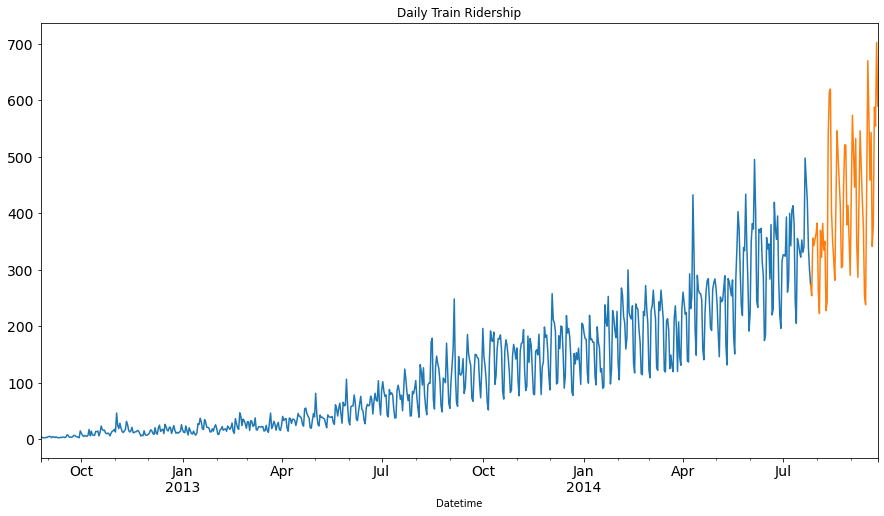

In [ ]:
train.Count.plot(figsize=(15,8), title="Daily Train Ridership", fontsize=14);
valid.Count.plot(figsize=(15,8), title="Daily Train Ridership", fontsize=14)
plt.show()

# **Determine Rolling statistics**

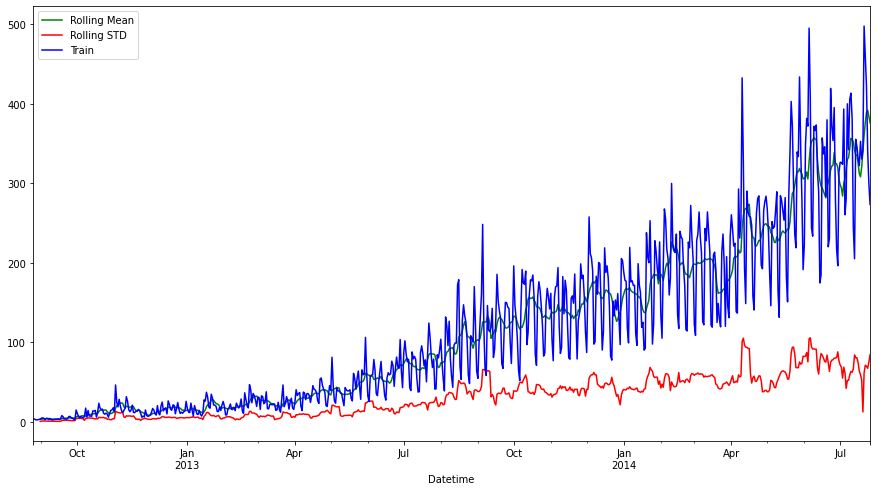

In [ ]:
# Determine rolling stats
rolmean  = train.Count.rolling(window=7).mean()
rolstd = train.Count.rolling(7).std()
rolmean = rolmean.dropna()
rolstd = rolstd.dropna()

plt.figure(figsize=(15,8))
rolmean.plot(label="Rolling Mean", color='green')
rolstd.plot(label="Rolling STD", color='red')
train.Count.plot(label="Train", color='blue')
plt.legend(loc='best')

In [ ]:
# Check if stationary
result = adfuller(train.Count, autolag='AIC')
df_out = pd.DataFrame(result[0:4], index=['Test Statistics', 'p-value', 'Number of lags used', 'Number of observations used'])
df_out

,0
Test Statistics,1.42149
p-value,0.99721
Number of lags used,20.00000
Number of observations used,680.00000


# **Logs Scale transformation**

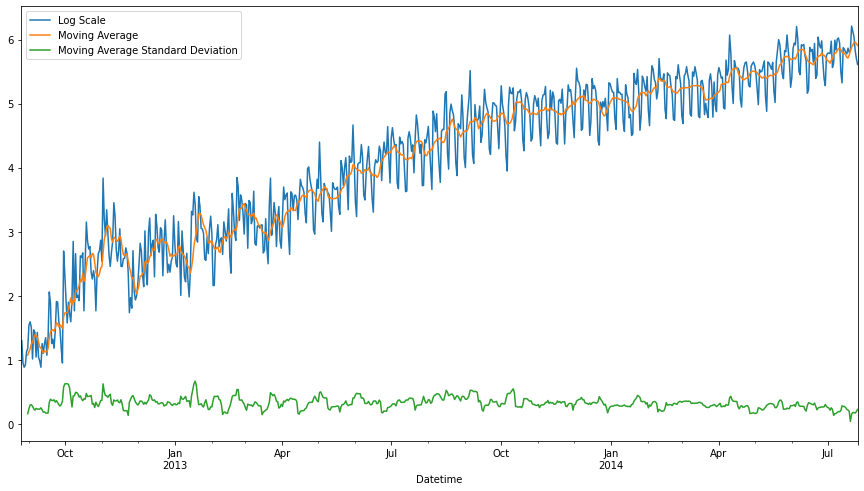

In [ ]:
train_Count_log = np.log(train.Count)

moving_avg = train_Count_log.rolling(window=7).mean()
moving_avg_std = train_Count_log.rolling(window=7).std()

plt.figure(figsize=(15,8))
train_Count_log.plot(label="Log Scale")
moving_avg.plot(label="Moving Average")
moving_avg_std.plot(label="Moving Average Standard Deviation")
plt.legend()
plt.show()

logscaleL=stationarypart(L1)+trend(LT)
movingavgoflogscaleA=stationarypart(A1)+trend(AT)
resultseriesR=L−A=(L1+LT)−(A1+AT)=(L1−A1)+(LT−AT)
Since, L & A are series & it moving avg, their trend will be more or less same, Hence LT-AT nearly equals to 0

Thus trend component will be almost removed. And we have,

R=L1−A1 , our final non-trend curve

In [ ]:
train_Count_log

Datetime
2012-08-25    1.152680
2012-08-26    1.299283
2012-08-27    0.949081
2012-08-28    0.882389
2012-08-29    0.916291
                ...   
2014-07-22    6.128687
2014-07-23    6.045203
2014-07-24    5.828455
2014-07-25    5.702671
2014-07-26    5.610997
Freq: D, Name: Count, Length: 701, dtype: float64

In [ ]:
newtrain = train.copy()

In [ ]:
train.shape

(701, 6)

In [ ]:
valid.shape

(62, 6)

In [ ]:
newtrain.append(valid)

,ID,Count,year,Month,day,hour
Datetime,,,,,,
2012-08-25,11.5,3.166667,2012.0,8.0,25.0,11.5
2012-08-26,35.5,3.666667,2012.0,8.0,26.0,11.5
2012-08-27,59.5,2.583333,2012.0,8.0,27.0,11.5
2012-08-28,83.5,2.416667,2012.0,8.0,28.0,11.5
2012-08-29,107.5,2.500000,2012.0,8.0,29.0,11.5
...,...,...,...,...,...,...
2014-09-21,18179.5,379.250000,2014.0,9.0,21.0,11.5
2014-09-22,18203.5,588.166667,2014.0,9.0,22.0,11.5
2014-09-23,18227.5,554.333333,2014.0,9.0,23.0,11.5


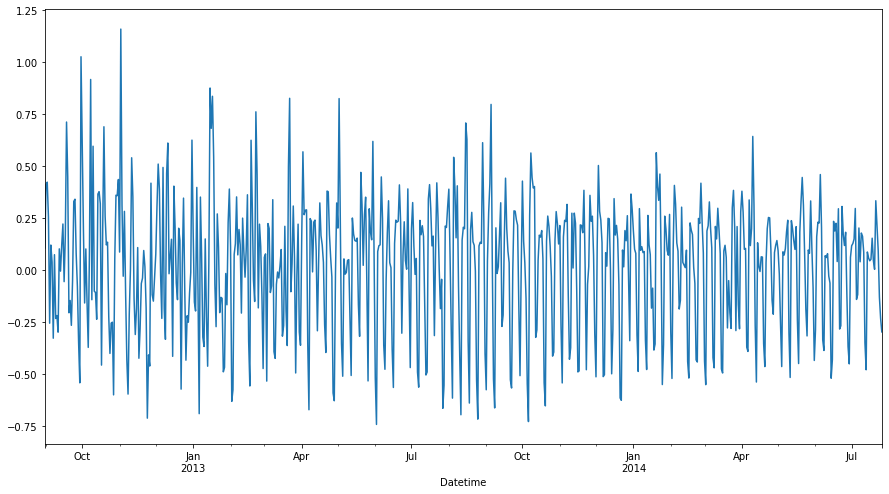

In [ ]:
dif_log = train_Count_log - moving_avg
dif_log = dif_log.dropna()

plt.figure(figsize=(15,8))
dif_log.plot()
plt.show()

In [ ]:
def test_stationary(timeseries):
  moving_avg = timeseries.rolling(window=7).mean()
  moving_avg_std = timeseries.rolling(window=7).std()
  plt.figure(figsize=(15,8))
  plt.plot(moving_avg, label ="Rolling Mean", color='red')
  plt.plot(moving_avg_std, label="Rolling STD", color='green')
  plt.plot(timeseries)
  plt.legend(loc='best')

  print("Results of Dickey-fuller Test")
  result = adfuller(timeseries, autolag='AIC')
  dfout = pd.DataFrame(result[0:4], index =['Test statistics', 'p-value', '#Lags used', 'Number of observations used'])
  print(dfout)
  for key, value in result[4].items():
    print("Critical value {}: {}".format(key, value))


Results of Dickey-fuller Test
                                        0
Test statistics             -6.409070e+00
p-value                      1.910756e-08
#Lags used                   2.000000e+01
Number of observations used  6.740000e+02
Critical value 1%: -3.4400894360545475
Critical value 5%: -2.865837730028723
Critical value 10%: -2.5690586760471605


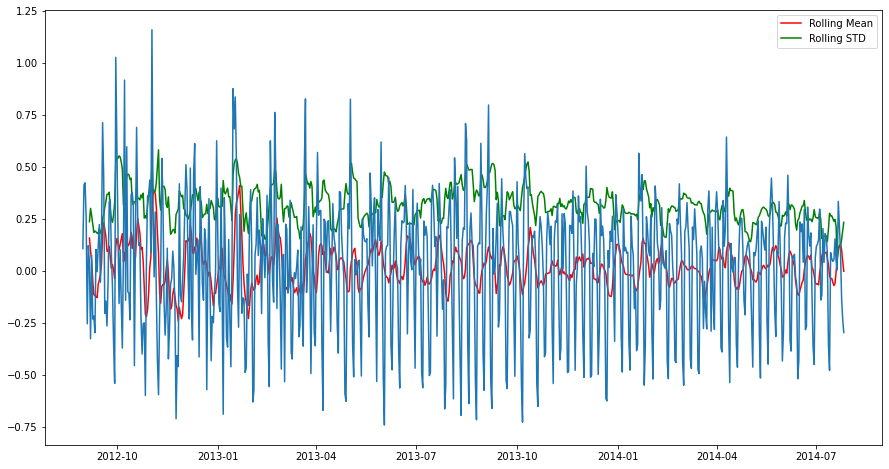

In [ ]:
test_stationary(dif_log)

In [ ]:
float(2.000000e+01)

20.0

# **Exponential Decay Transformation**

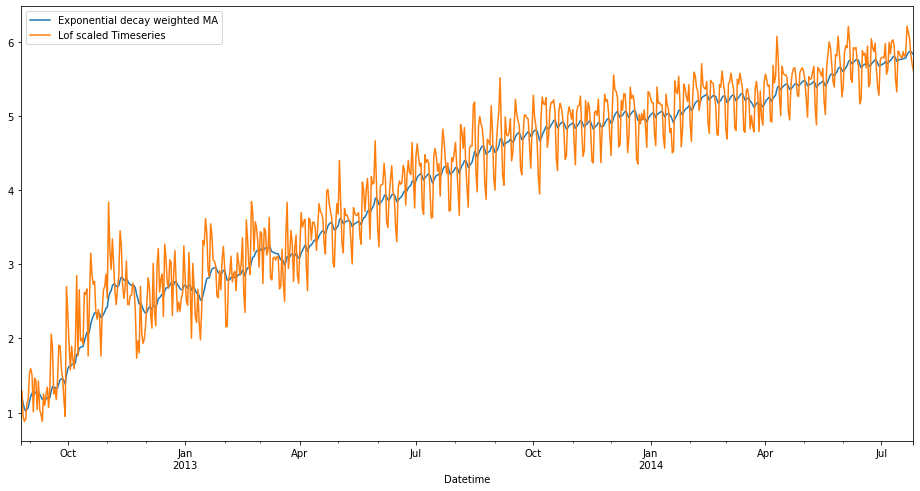

In [ ]:
edw_avg = train_Count_log.ewm(halflife=7, min_periods=0, adjust=True).mean()

plt.figure(figsize=(16,8))
edw_avg.plot(label='Exponential decay weighted MA')
train_Count_log.plot(label='Lof scaled Timeseries')
plt.legend(loc='best')
plt.show()

Results of Dickey-fuller Test
                                      0
Test statistics               -5.559150
p-value                        0.000002
#Lags used                    20.000000
Number of observations used  680.000000
Critical value 1%: -3.4400031721739515
Critical value 5%: -2.865799725091594
Critical value 10%: -2.569038427768166


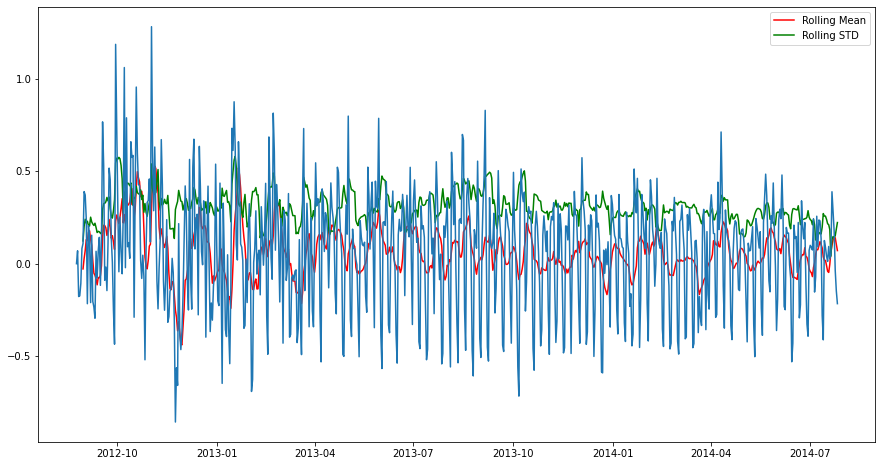

In [ ]:
# ADCF test
diff_ewd_log_Scaled_ts = train_Count_log - edw_avg
diff_ewd_log_Scaled_ts.dropna(inplace=True)
test_stationary(diff_ewd_log_Scaled_ts)

P-value leass than 0.5 and Test stattistcs value less than cirtical value, that shows the time series follows stationarity

# **Time shift transformation**

Given a set of observation on the time series:

x0,x1,x2,x3,....xn The shifted values will be:
null,x0,x1,x2,....xn <---- basically all xi's shifted by 1 pos to right
Thus, the time series with time shifted values are:

null,(x1−x0),(x2−x1),(x3−x2),(x4−x3),....(xn−xn−1)

Results of Dickey-fuller Test
                                        0
Test statistics             -8.392998e+00
p-value                      2.339203e-13
#Lags used                   1.900000e+01
Number of observations used  6.800000e+02
Critical value 1%: -3.4400031721739515
Critical value 5%: -2.865799725091594
Critical value 10%: -2.569038427768166


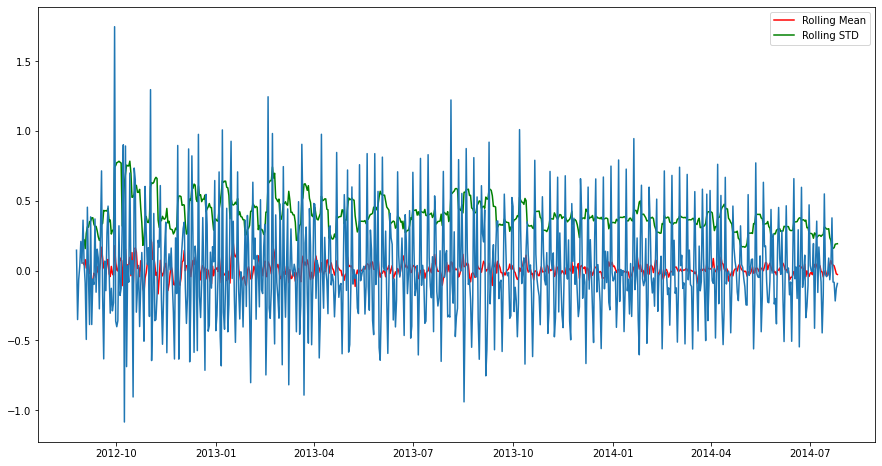

In [ ]:
diff_logscales_ts_shift = train_Count_log - train_Count_log.shift()
diff_logscales_ts_shift.dropna(inplace=True)
test_stationary(diff_logscales_ts_shift)

# **Decomposition**

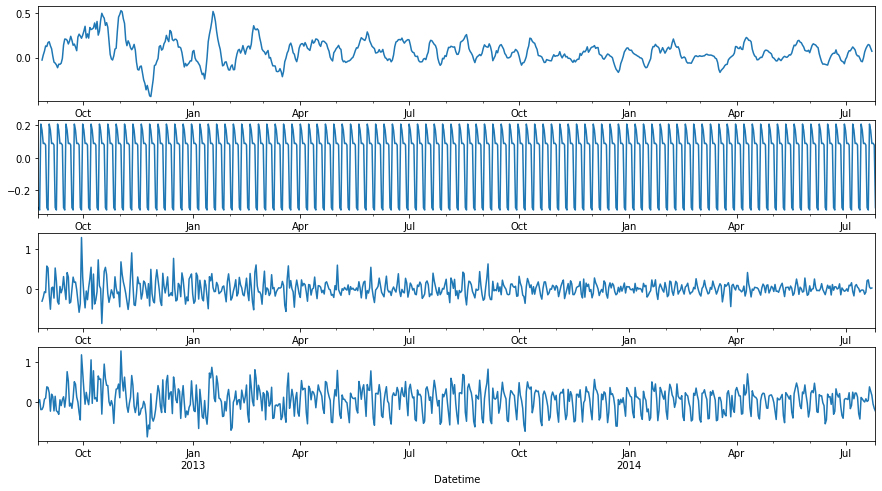

Results of Dickey-fuller Test
                                        0
Test statistics             -1.148037e+01
p-value                      5.011774e-21
#Lags used                   2.000000e+01
Number of observations used  6.740000e+02
Critical value 1%: -3.4400894360545475
Critical value 5%: -2.865837730028723
Critical value 10%: -2.5690586760471605


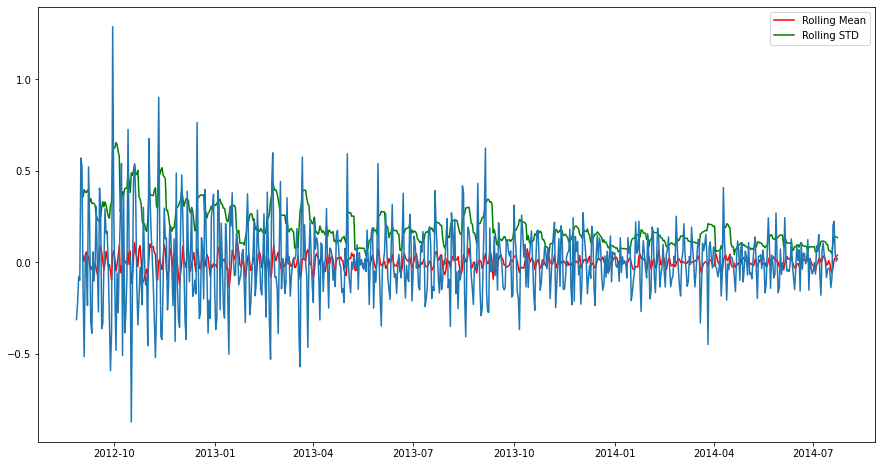

In [ ]:
decompose  = seasonal_decompose(diff_ewd_log_Scaled_ts )
trend = decompose.trend
seasonal = decompose.seasonal
resid = decompose.resid

plt.figure(figsize=(15,8))
plt.subplot(4,1,1)
trend.plot(label='Trend')
plt.subplot(412)
seasonal.plot(label="Seasonality")
plt.subplot(413)
resid.plot(label="Residuals")
plt.subplot(414)
diff_ewd_log_Scaled_ts.plot(label="DifEfrence of weghted MA")
plt.show()

decom_log_data = resid
decom_log_data.dropna(inplace=True)
test_stationary(decom_log_data)

# **ACF and PACF plots for approximating q and p values approximately**

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning:

fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.



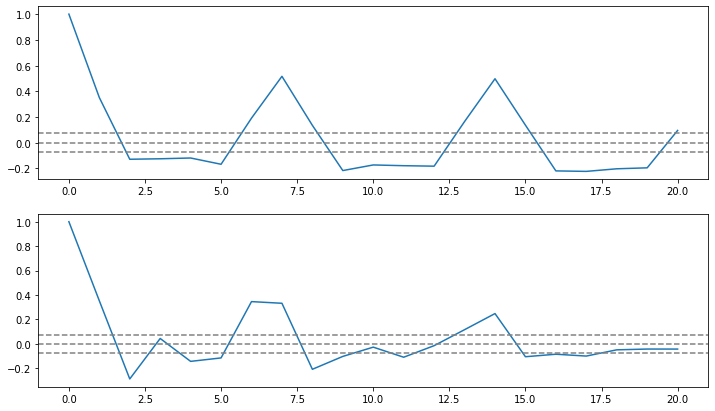

In [ ]:
lag_acf = acf(diff_ewd_log_Scaled_ts, nlags=20)
lag_pacf = pacf(diff_ewd_log_Scaled_ts, nlags=20)

# Plot ACF
fig=plt.figure(figsize=(12,7))
plt.subplot(211)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(diff_ewd_log_Scaled_ts)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(diff_ewd_log_Scaled_ts)), linestyle='--', color='gray')

plt.subplot(212)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(diff_ewd_log_Scaled_ts)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(diff_ewd_log_Scaled_ts)), linestyle='--', color='gray')

# **Build Model**

RSS : 0.0045


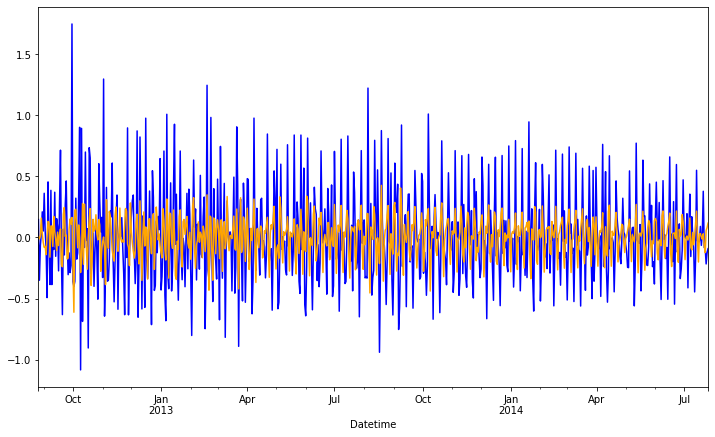

In [ ]:
# Build AR Model
model = ARIMA(train_Count_log, order=(2,1,0))
result_AR = model.fit(disp=0)

fig=plt.figure(figsize=(12,7))
diff_logscales_ts_shift.plot(color='blue')
result_AR.fittedvalues.dropna(inplace=True)
result_AR.fittedvalues.plot(color='orange')

df= pd.concat([result_AR.fittedvalues, diff_logscales_ts_shift], axis=1).dropna()
print("RSS : %.4f"% np.sum(df[0]-df['Count'])**2)




RSS : 0.2907


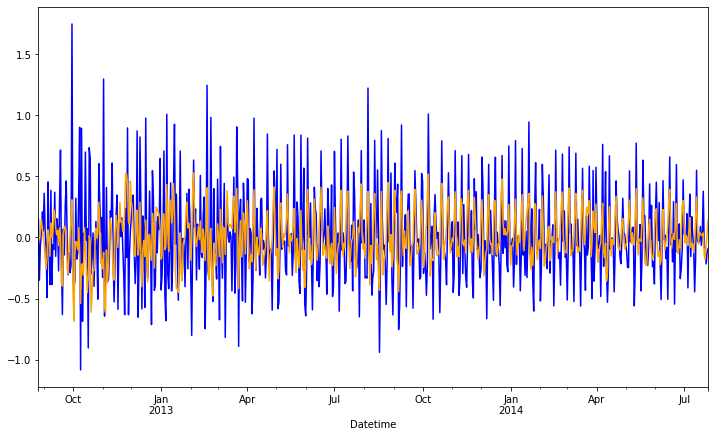

In [ ]:
# Build MA Model
model = ARIMA(train_Count_log, order=(0,1,2))
result_MA = model.fit(disp=0)

fig=plt.figure(figsize=(12,7))
diff_logscales_ts_shift.plot(color='blue')
result_MA.fittedvalues.dropna(inplace=True)
result_MA.fittedvalues.plot(color='orange')

df= pd.concat([result_MA.fittedvalues, diff_logscales_ts_shift], axis=1).dropna()
print("RSS : %.4f"% np.sum(df[0]-df['Count'])**2)

RSS : 0.0738


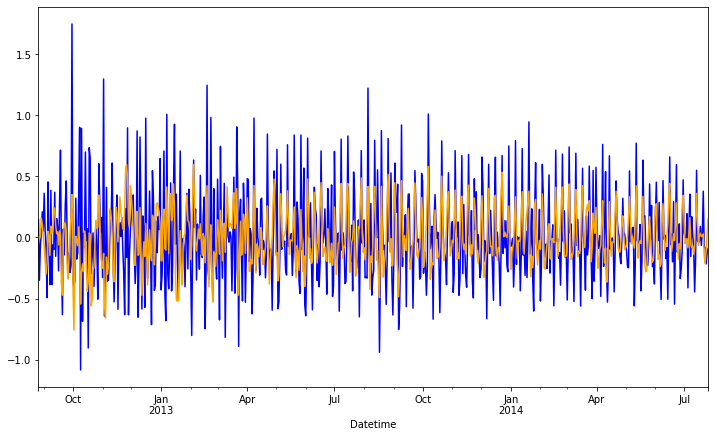

In [ ]:
# Build ARIMA Model
model = ARIMA(train_Count_log, order=(2,1,2))
result_ARIMA = model.fit(disp=0)

fig=plt.figure(figsize=(12,7))
diff_logscales_ts_shift.plot(color='blue')
result_ARIMA.fittedvalues.dropna(inplace=True)
result_ARIMA.fittedvalues.plot(color='orange')

df= pd.concat([result_ARIMA.fittedvalues, diff_logscales_ts_shift], axis=1).dropna()
print("RSS : %.4f"% np.sum(df[0]-df['Count'])**2)

# **Prediction and Reverse Transformations**

Datetime
2012-08-25    1.152680
2012-08-26    1.159202
2012-08-27    1.148059
2012-08-28    1.162253
2012-08-29    1.321599
Freq: D, dtype: float64


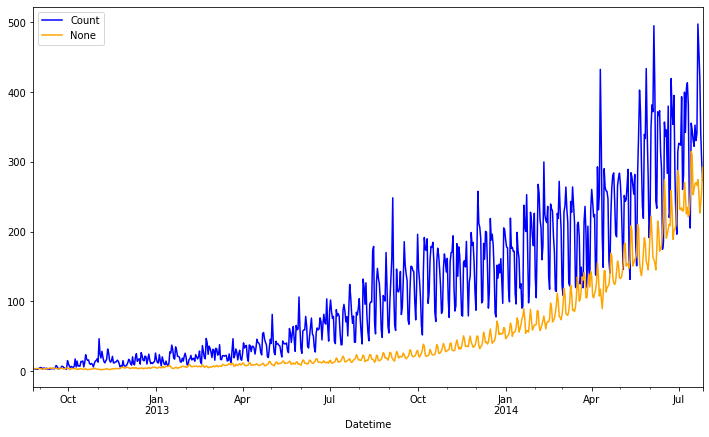

In [ ]:
# Using AR Model

# Taking Cumulative sum
pred_ar_dif = pd.Series(result_AR.fittedvalues, copy=True)
pred_ar_dif_cumsum = pred_ar_dif.cumsum()

# Adding cumulative sum to log scaled train data
pred_ar_log = pd.Series(train_Count_log.iloc[0], index=train_Count_log.index)
pred_ar_log = pred_ar_log.add(pred_ar_dif_cumsum, fill_value=0)
print(pred_ar_log.head())

# inverse of log is exp
pred_ar = np.exp(pred_ar_log)
plt.figure(figsize=(12,7))
train.Count.plot(color='blue')
pred_ar.plot(color='orange')
plt.legend()


# **Validation**

In [ ]:
def validation(order):
  valid_count_log = list(np.log(valid.Count).values)
  history = list(train_Count_log.values)
  model = ARIMA(history, order=order)
  model_fit = model.fit(disp=0)
  pred = model_fit.forecast(steps=len(valid))
  mse = mean_squared_error(valid_count_log, pred[0])
  rmse = np.sqrt(mse)
  print("MSE: %.4f"% mse)
  print("RMSE: %.4f"% rmse)


  fig=plt.figure(figsize=(12,7))
  prediction = np.exp(pred[0])
  prediction = pd.Series(prediction, index=valid.index)
  train.Count.plot(label="Train", color='blue')
  valid.Count.plot(label ="Valid" , color='green')
  prediction.plot(label ="Prediction", color='red')
  plt.show()

MSE: 0.0772
RMSE: 0.2778


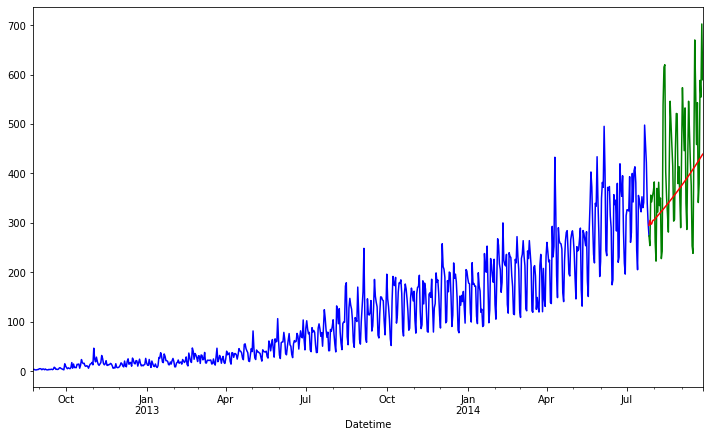

In [ ]:
validation((2,1,0))

# **Test forecasting**

In [ ]:
history = list(np.log(train_original.Count).values)
model = ARIMA(history, order=(2,1,0))
model_fit = model.fit(disp=0)
pred = model_fit.forecast(steps=len(test_original))

predictions = np.exp(pred[0])

In [ ]:
predictions

array([ 554.0631712 ,  550.19608397,  550.52954317, ..., 1969.80612438,
       1970.29781731, 1970.78963298])

# **Submission**

In [ ]:
submit= pd.DataFrame(predictions, index=test_original['ID'], columns=['Count'])

In [ ]:
submit.to_csv("submission.csv")

Test forecasting

RSS : 0.0045


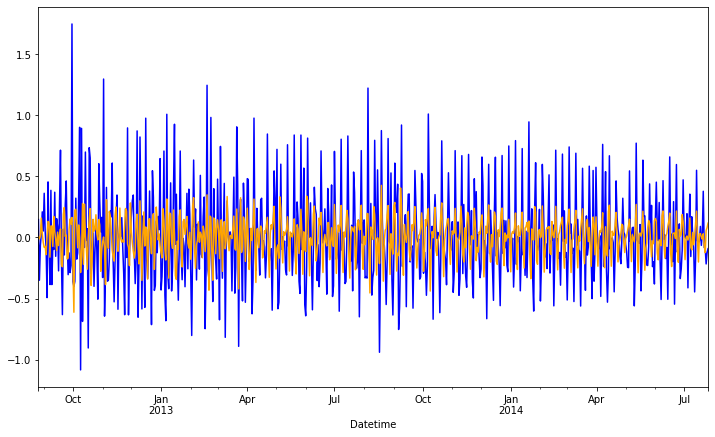

In [ ]:
model = ARIMA(train_Count_log, order=(2,1,0))
result_AR = model.fit(disp=0)

fig=plt.figure(figsize=(12,7))
diff_logscales_ts_shift.plot(color='blue')
result_AR.fittedvalues.dropna(inplace=True)
result_AR.fittedvalues.plot(color='orange')

df= pd.concat([result_AR.fittedvalues, diff_logscales_ts_shift], axis=1).dropna()
print("RSS : %.4f"% np.sum(df[0]-df['Count'])**2)

In [ ]:
hist = train.copy()
hist = hist.append(valid)
hist_Count_log = list(np.log(hist.Count).values)

In [ ]:
model = ARIMA(hist_Count_log, order=(2,1,0))
model_fit = model.fit(disp=0)
predictions = model_fit.forecast(steps=len(test_df))

# **Reverse Transformations**

In [ ]:
test_df.shape

(213, 5)

In [ ]:
predictions[0].shape

(213,)

In [ ]:
test_df['pred']=np.exp(predictions[0])

In [ ]:
test_df

,ID,year,Month,day,hour,pred
Datetime,,,,,,
2014-09-26,18299.5,2012.0,8.0,25.0,11.5,559.670657
2014-09-27,18323.5,2012.0,8.0,26.0,11.5,610.661778
2014-09-28,18347.5,2012.0,8.0,27.0,11.5,620.893215
2014-09-29,18371.5,2012.0,8.0,28.0,11.5,605.066392
2014-09-30,18395.5,2012.0,8.0,29.0,11.5,610.269039
...,...,...,...,...,...,...
2015-04-22,23291.5,2013.0,3.0,21.0,11.5,2523.364065
2015-04-23,23315.5,2013.0,3.0,22.0,11.5,2540.888458
2015-04-24,23339.5,2013.0,3.0,23.0,11.5,2558.534555


In [ ]:
train_original['ratio']=train_original['Count']/train_original['Count'].sum() 
temp=train_original.groupby('hour')['ratio'].sum().reset_index()

merge=pd.merge(test_df, test_original, on=('Month','day', 'year'), how='left')
print(merge)
# merge['hour']=merge.hour_x
# merge['ID']=merge['ID_y']
# merge=merge.drop(['ID_x', 'Datetime','hour_y','ID_y'], axis=1) 
# # print(merge)
# merge['hour'] = merge.hour_x
# pred=pd.merge(merge, temp, on='hour', how='left')

# # convert the ratio to the original scale
# pred['Count']=pred['pred']*pred['ratio']*24

        ID_x    year  Month   day  hour_x         pred  ID_y Datetime  hour_y
0    18299.5  2012.0    8.0  25.0    11.5   559.670657   NaN      NaT     NaN
1    18323.5  2012.0    8.0  26.0    11.5   610.661778   NaN      NaT     NaN
2    18347.5  2012.0    8.0  27.0    11.5   620.893215   NaN      NaT     NaN
3    18371.5  2012.0    8.0  28.0    11.5   605.066392   NaN      NaT     NaN
4    18395.5  2012.0    8.0  29.0    11.5   610.269039   NaN      NaT     NaN
..       ...     ...    ...   ...     ...          ...   ...      ...     ...
208  23291.5  2013.0    3.0  21.0    11.5  2523.364065   NaN      NaT     NaN
209  23315.5  2013.0    3.0  22.0    11.5  2540.888458   NaN      NaT     NaN
210  23339.5  2013.0    3.0  23.0    11.5  2558.534555   NaN      NaT     NaN
211  23363.5  2013.0    3.0  24.0    11.5  2576.303202   NaN      NaT     NaN
212  23387.5  2013.0    3.0  25.0    11.5  2594.195250   NaN      NaT     NaN

[213 rows x 9 columns]


# **Facebook Prophet**

In [ ]:
def date_parser(x):
    return pd.datetime.strptime(x, '%d-%m-%Y %H:%M')


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning:

The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.

INFO:fbprophet:Found custom seasonality named 'weekly', disabling built-in 'weekly' seasonality.


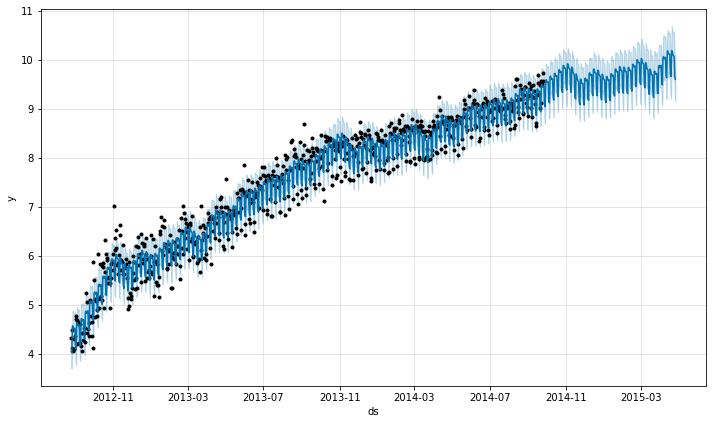

In [ ]:
train_data = pd.read_csv(train_path, parse_dates = [1], date_parser = date_parser)
test_data = pd.read_csv(test_path, parse_dates = [1], date_parser = date_parser)
train_data.columns = train_data.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')
test_data.columns = test_data.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '')

train_data['date'] = train_data['datetime'].dt.date
train_data = train_data.groupby(['date'])['count'].sum().reset_index()
train_data.columns = ['ds', 'y']
train_data['y'] = np.log(train_data['y'])
model = Prophet(daily_seasonality = False)
model.add_seasonality(name = 'weekly', period = 7, fourier_order = 300)
model.fit(train_data)
future = model.make_future_dataframe(periods = 213)
forecast = model.predict(future)
fig1 = model.plot(forecast)

In [ ]:
forecast['yhat']

0       4.052173
1       4.018511
2       4.562180
3       4.568054
4       4.511102
         ...    
970    10.096513
971    10.080518
972    10.067411
973     9.655249
974     9.597454
Name: yhat, Length: 975, dtype: float64

In [ ]:
f_preds = np.exp(forecast[-213:]['yhat']).values
er = []
listm = [0.044286588, 0.035343014, 0.029911076, 0.024714453, 0.02080223, 0.018621427, 
         0.020023091, 0.023221497, 0.026741002, 0.034555218, 0.049047207, 0.05437526, 
         0.054951351, 0.048600186, 0.051965438, 0.051309072, 0.049999488, 0.051164262, 
         0.052423477, 0.055626605, 0.053455246, 0.049894816, 0.050075828, 0.048892166]
for p in range(len(f_preds)):
    for l in range(len(listm)):
        er.append(f_preds[p]*listm[l])

Result = {'Count': er}

submission_df = pd.DataFrame({
                  "ID": pd.Series([x + 18288 for x in range(5112)]), 
                  "Count": pd.Series(Result['Count'])})
# submission_df.to_csv('submission_1.csv', index = False)